In [32]:
from torchkge import models
import torch
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')


In [21]:
root_file = './data/CLEAN_DB_FOR_GNN_17_02/'
train = pd.read_csv(os.path.join(root_file, 'train.txt'), header=None, names=['h', 'r', 't'])
test = pd.read_csv(os.path.join(root_file, 'test.txt'), header=None, names=['h', 'r', 't'])
map_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT__MAPPING.csv'))
db2index = dict(zip(map_.DB_ID, map_.INDEX))
index2db = dict(zip(map_.INDEX, map_.DB_ID))
emb_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT.csv'))
mapping = {}
for i, row in emb_.iterrows():
    mapping[row['DB_ID']] = row[:-1].values
db_ids = db2index.keys()
assert len(set(index2db.keys()).difference(train['h'].unique().tolist()+train['t'].unique().tolist()+test['h'].unique().tolist()+test['t'].unique().tolist())) == 0
print("Unique nodes: %d" % len(db2index))

Unique nodes: 1476


In [23]:
pairs = train['h'].astype(str) + '_' + train['t'].astype(str)
x_train_pairs = list(set(pairs))
print("TRAIN")
print(len(pairs), len(x_train_pairs))

pairs = test['h'].astype(str) + '_' + test['t'].astype(str)
x_test_pairs = list(set(pairs))
print("TEST")
print(len(pairs), len(x_test_pairs))

TRAIN
170381 170381
TEST
304597 304597


In [229]:
df_emb = pd.read_csv('./Emb/CLEAN_DB_FOR_GNN_17_02/_TransE_ENT_EMB.csv')
df_rel = pd.read_csv('./Emb/CLEAN_DB_FOR_GNN_17_02/_TransE_REL_EMB.csv')
node_list = df_emb[df_emb.columns[-1]]
rel_list = df_rel[df_rel.columns[-1]]
del df_emb[df_emb.columns[-1]]
del df_rel[df_rel.columns[-1]]
nodes_emb = df_emb.values
rel_emb = df_rel.values
print(nodes_emb.shape)
print(rel_emb.shape)

(1476, 768)
(1, 768)


In [188]:
def show_metrics_pos(y_true, y_score, wanted_indexes=None, print_=True, neg_label=0, pos_label=1):
    if wanted_indexes:
        y_true = y_true[wanted_indexes]
        y_score = y_score[wanted_indexes]
    if neg_label != 0:
        y_true[y_true==neg_label] = 0
        y_score[y_score==neg_label] = 0
    if pos_label != 1:
        y_true[y_true==pos_label] = 1
        y_score[y_score==pos_label] = 1
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # False negative
    fn = np.sum(y_true * (y_score==0))
    # tn
    tn = np.sum((y_true == 0) * (y_score==0))
    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # Precision
    precision = tp / (tp + fp)
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
#     print("True positive: ", tp)
#     print("False positive: ", fp)
#     print("False negative: ", fn)
    total = tp + fp +fn +tn
    if print_:
        print("True positive: %d (%0.2f %%)" % (tp, 100*float(tp)/total))
        print("False positive: %d (%0.2f %%)" % (fp, 100*float(fp)/total))
        print("False negative: %d (%0.2f %%)" % (fn, 100*fn/total))
        print("True negative: %d (%0.2f %%)" % (tn, 100*tn/total))
        print("Total #: ", total)
        print("True positive rate (recall): ", tpr)
        print("Precision: ", precision)
        print("F1: ", f1)
    return precision, tpr, f1

In [26]:
import numpy as np
def get_sparsity(A):
    return 1.0 - ( np.count_nonzero(A) / float(A.size) )

# Adj matrix (train)

adj_train = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_train_pairs:
    splits = item.split("_")
    try:
        adj_train[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue
        
        
print("Sparsity Train: %0.2f%%"%(100*get_sparsity(adj_train)))

adj_test = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_test_pairs:
    splits = item.split("_")
    try:
        adj_test[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue

print("Sparsity Test: %0.2f%%"%(100*get_sparsity(adj_test)))

adj_all = np.zeros_like(adj_train, dtype=np.int8)
adj_all = adj_train + adj_test
adj_all = np.clip(adj_all, 0, 1)
print("Sparsity Total: %0.2f%%"%(100*get_sparsity(adj_all)))

Sparsity Train: 92.18%
Sparsity Test: 86.02%
Sparsity Total: 78.20%


In [230]:
#Print Total Result
X_est = []
c = 0
est_every = 10000
y_pred = []
for i in tqdm_notebook(range(len(adj_all))):
    for j in range(len(adj_all)):
        y_pred.append(np.linalg.norm(nodes_emb[int(i)] + rel_emb[0] - nodes_emb[int(j)]))
#         X_est.append(np.concatenate([mapping[int(i)], mapping[int(j)]]).reshape(1,-1))
#         c += 1
#         if c == est_every:
#             X_est = np.array(X_est).reshape(len(X_est), -1)
#             X_est = StandardScaler().fit_transform(X_est)
#             y_pred.extend(est.predict(X_est).ravel().tolist())
#             c = 0
#             X_est = []
# For what's left
#if c > 0:
#     X_est = np.array(X_est).reshape(len(X_est), -1)
#     y_pred.extend(est.predict(X_est).ravel().tolist())
#     c = 0
#     X_est = []

/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars



True positive: 37447 (1.72 %)
False positive: 113055 (5.19 %)
False negative: 267150 (12.26 %)
True negative: 1760924 (80.83 %)
Total #:  2178576
True positive rate (recall):  0.12293949053995935
Precision:  0.24881396924957808
F1:  0.16456639104898055


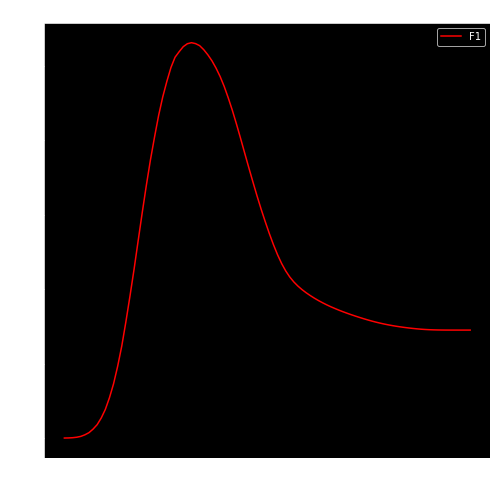

In [231]:
fs = []

adj_pred = np.array(y_pred).reshape(adj_test.shape)
# adj_pred = torch.matmul(torch.matmul(torch.Tensor(nodes_emb), R[0]), torch.Tensor(nodes_emb.T)).detach().numpy()
thresholds = np.linspace(np.min(adj_pred), np.max(adj_pred), 100)
#adj_pred.fill_diagonal(np.max(adj_pred))
for tr in tqdm_notebook(thresholds):
    cur_ = adj_pred.copy()
    cur_ = (cur_ < tr).astype(np.int_)
    #cur_[cur_>= tr] = 0
    #cur_[cur_< tr] = 1
    #print(tr)
    #print(cur_.sum())
    _, _, f = show_metrics_pos(adj_train.ravel(), cur_.ravel(), print_=False)
    fs.append(f)

tr = thresholds[np.argmax(fs)]
plt.figure(figsize=(8, 8))
plt.plot(thresholds, fs, "r-", label="F1")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')
plt.title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(fs)))

# Binarize
cur_ = adj_pred.copy().reshape(adj_test.shape)
#np.fill_diagonal(cur_, np.max(cur_))
cur_ = (cur_ < tr).astype(np.int_)
_, _, _ = show_metrics_pos(adj_test.ravel(), cur_.ravel())

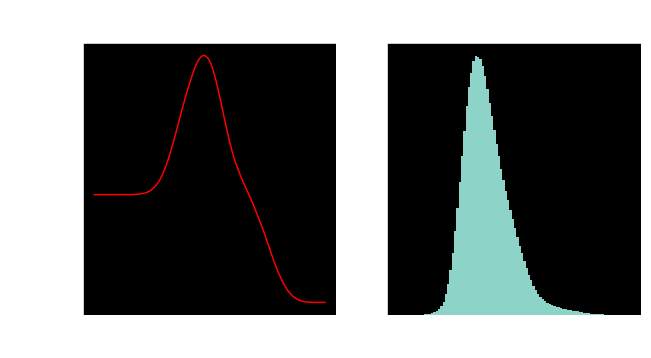

In [238]:
def plot_dist(name, thresholds, fs, adj_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=False)
    axes[0].plot(thresholds, fs, "r-", label="F1")
    axes[0].set_xlabel('Distances', fontsize=15)
    axes[0].set_ylabel('Train F1', fontsize=15)
    axes[0].set_title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(fs)), fontsize=15)

    axes[1].hist(adj_pred.ravel(), density=True, bins=100)
    axes[1].set_xlabel('Scores', fontsize=15)
    axes[1].set_ylabel('Counts', fontsize=15)
    axes[1].set_title("Distribution", fontsize=15)
    plt.suptitle('%s' % name, fontsize=15)
    plt.savefig('/media/kostas/DATA/LLD/Papers/RESEARCH/BIOBERT_DRUGBANK/PhD_Progress/%s_EMB.png' % name, dpi=300)
    


In [205]:
xx = axes[0]
xx.set_xlabel('la')

Text(0.5,3.2,'la')

TypeError: 'Text' object is not callable

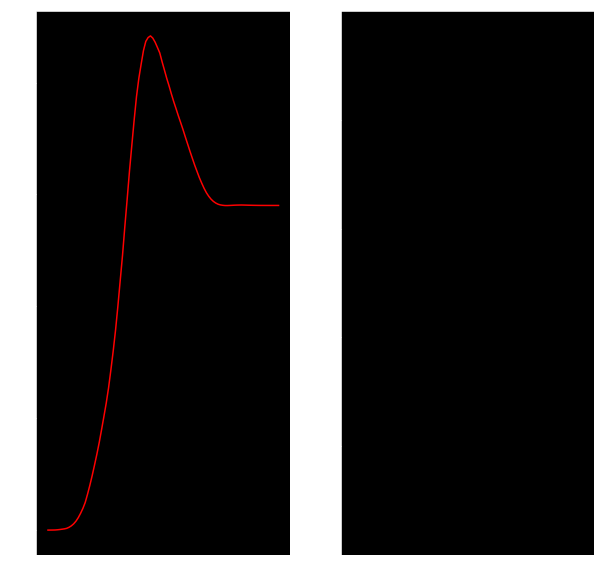

In [197]:
tr = thresholds[np.argmax(fs)]

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(thresholds, fs, "r-", label="F1")
#ax1.ylabel('la')
#ax1.xlabel("Decision Threshold")
ax title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(fs)))

ax2.plot(adj_pred.ravel())
ax2.ylabel("Score")
ax2.xlabel("Decision Threshold")
ax2.legend(loc='best')
ax2.title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(fs)))

In [186]:
_, _, _ = show_metrics_pos(adj_test.ravel(), cur_.ravel())

True positive: 69507 (3.19 %)
False positive: 304035 (13.96 %)
False negative: 235090 (10.79 %)
True negative: 1569944 (72.06 %)
Total #:  2178576
True positive rate (recall):  0.2281933177280144
Precision:  0.1860754613938995
F1:  0.20499337156541653


In [254]:
df_emb = pd.read_csv('./Emb/CLEAN_DB_FOR_GNN_17_02/_HolE_ENT_EMB.csv')
df_rel = pd.read_csv('./Emb/CLEAN_DB_FOR_GNN_17_02/_HolE_REL_EMB.csv')
node_list = df_emb[df_emb.columns[-1]]
rel_list = df_rel[df_rel.columns[-1]]
del df_emb[df_emb.columns[-1]]
#del df_rel[df_rel.columns[-1]]
nodes_emb = df_emb.values
rel_emb = df_rel.values
print(nodes_emb.shape)
print(rel_emb.shape)

(1476, 768)
(1, 769)


In [249]:
R = torch.load('./Emb/CLEAN_DB_FOR_GNN_17_02/_RESCAL_REL_MATRIX.pt', map_location=torch.device('cpu'))
adj_pred = torch.matmul(torch.matmul(torch.Tensor(nodes_emb), R[0]), torch.Tensor(nodes_emb.T)).detach().numpy()

In [259]:
from torchkge.utils import get_rolling_matrix
relation_matrices = get_rolling_matrix(torch.Tensor(rel_emb))

In [268]:
node_list

0          0
1          1
2          2
3          3
4          4
        ... 
1471    1471
1472    1472
1473    1473
1474    1474
1475    1475
Name: ID, Length: 1476, dtype: int64

In [263]:
adj_pred = torch.matmul(torch.matmul(torch.Tensor(nodes_emb), relation_matrices[0]), torch.Tensor(nodes_emb.T)).detach().numpy()

RuntimeError: size mismatch, m1: [1476 x 768], m2: [769 x 769] at /opt/conda/conda-bld/pytorch_1579022030672/work/aten/src/TH/generic/THTensorMath.cpp:136

/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/media/kostas/DATA/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

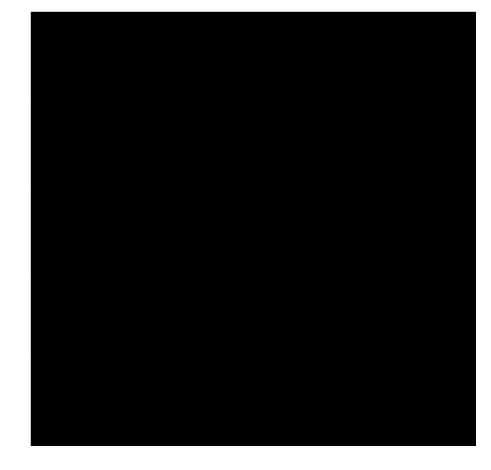

In [256]:


#adj_pred = np.array(y_pred).reshape(adj_test.shape)
adj_pred = torch.matmul(torch.matmul(torch.Tensor(nodes_emb), R[0]), torch.Tensor(nodes_emb.T)).detach().numpy()
thresholds = np.linspace(np.min(adj_pred), np.max(adj_pred), 100)
#adj_pred.fill_diagonal(np.max(adj_pred))
for tr in tqdm_notebook(thresholds):
    cur_ = adj_pred.copy()
    cur_ = (cur_ > tr).astype(np.int_)
    #cur_[cur_>= tr] = 0
    #cur_[cur_< tr] = 1
    #print(tr)
    #print(cur_.sum())
    _, _, f = show_metrics_pos(adj_train.ravel(), cur_.ravel(), print_=False)
    fs.append(f)

tr = thresholds[np.argmax(fs)]
plt.figure(figsize=(8, 8))
plt.plot(thresholds, fs, "r-", label="F1")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')
plt.title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(fs)))

# Binarize
cur_ = adj_pred.copy().reshape(adj_test.shape)
#np.fill_diagonal(cur_, np.max(cur_))
cur_ = (cur_ > tr).astype(np.int_)
_, _, _ = show_metrics_pos(adj_test.ravel(), cur_.ravel())

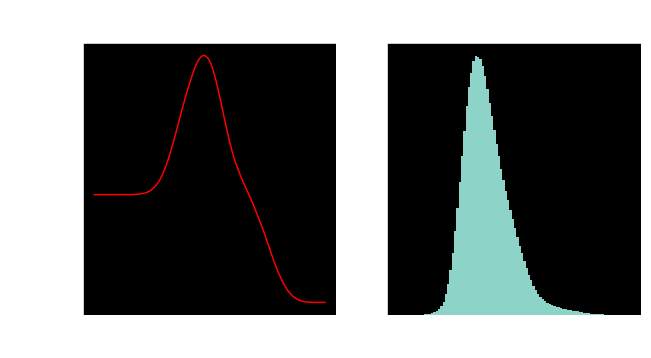

In [251]:
plot_dist('RESCAL_PRE', thresholds, fs, adj_pred)

In [178]:
adj_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)